# Bounded Bayesian Classifier Analysis

I have data of the form $\mathcal{D} = \{(x_i, y_i)\}_{i=1}^N$ where $x_i \in \mathbb{R}$ and $y_i \in \{\text{true}, \text{false}\}$. So, a 1D classification problem. But I also know:
1. The data obeys an unknown function $f_{a^*,b^*}(x) = [a^* < x < b^*]$.
2. There are known bounds on the unknown parameters: $a^* > a_{lo}$ and $b^* < b_{hi}$.

I want to come up with a probabilistic model that allows me to quickly evaluate $$P(y \mid x, a_{lo}, b_{hi}, \mathcal{D}).$$

As $\mathcal{D}$ gets larger, the model should approach the ground truth. And there should always be greater uncertainty in regions with less data.

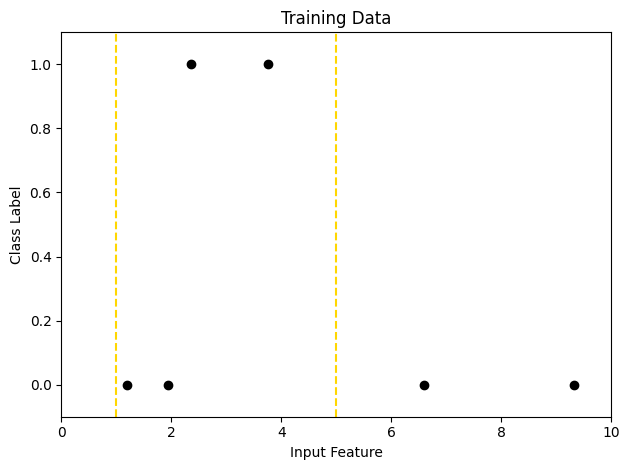

In [69]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

# Unknown model parameters.
a_star = 2.0
b_star = 4.0

# Known bounds on the model parameters.
a_lo = 1.0
b_hi = 5.0

# Generate some data.
X = np.random.normal(loc=5.0, scale=5.0, size=10)
y = np.logical_and(X >= a_star, X <= b_star)

# Specify inputs for testing later.
X_test = np.linspace(0.0, 10.0, num=100, endpoint=True)

# Plot the data.
plt.figure()
plt.title("Training Data")
plt.xlim((0.0, 10.0))
plt.ylim((-0.1, 1.1))
plt.xlabel("Input Feature")
plt.ylabel("Class Label")
plt.scatter(X, y, c="black")
plt.vlines([a_lo, b_hi], -0.1, 1.1, color="gold", linestyle="--")
plt.tight_layout()
plt.show()

## Logistic Regression

As a first pass, I will consider logistic regression, which will _not_ take the known bounds (2) into account. Note that we need to create features to introduce a linear decision boundary.

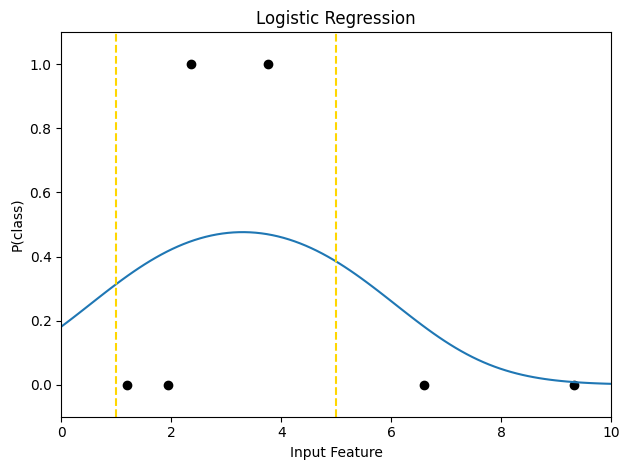

In [70]:
from sklearn.linear_model import LogisticRegression

# Create a linear decision boundary.
X_transformed = np.array([X, X**2]).T
X_test_transformed = np.array([X_test, X_test**2]).T

# Fit the model.
model = LogisticRegression()
model.fit(X_transformed, y)
logistic_regression_preds = model.predict_proba(X_test_transformed)[:, 1]

plt.figure()
plt.title("Logistic Regression")
plt.xlim((0.0, 10.0))
plt.ylim((-0.1, 1.1))
plt.xlabel("Input Feature")
plt.ylabel("P(class)")
plt.scatter(X, y, c="black")
plt.plot(X_test, logistic_regression_preds)
plt.vlines([a_lo, b_hi], -0.1, 1.1, color="gold", linestyle="--")
plt.tight_layout()
plt.show()

## Grid Search Inference

This approach may be slow, but it should be accurate.

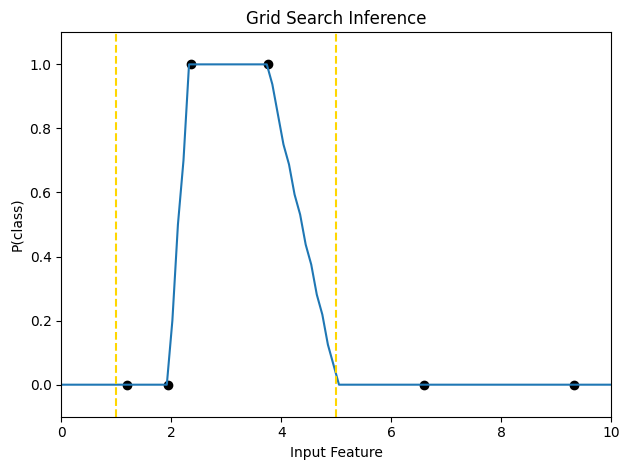

In [71]:
class GridSearchInference:
    """Learning is quadratic in num_grid_steps * linear in data size.

    Inference is quadratic in num_grid_steps.
    """

    def __init__(self, a_lo, b_hi, num_grid_steps = 100):
        self.a_lo = a_lo
        self.b_hi = b_hi
        self.num_grid_steps = num_grid_steps
        self.grid = []
        step_size = (b_hi - a_lo) / num_grid_steps
        for a in np.arange(a_lo, b_hi, step_size):
            for b in np.arange(a + step_size, b_hi + step_size, step_size):
                self.grid.append((a, b))
        self.active_grid = list(self.grid)

    def fit(self, X, Y):
        self.active_grid = []
        for a, b in self.grid:
            preds = np.logical_and(X >= a, X <= b)
            if np.all(preds == Y):
                self.active_grid.append((a, b))

    def predict_proba(self, X):
        all_preds = []
        for a, b in self.active_grid:
            preds = np.logical_and(X >= a, X <= b)
            all_preds.append(preds)
        mean_preds = np.mean(all_preds, axis=0)
        return mean_preds


model = GridSearchInference(a_lo, b_hi)
model.fit(X, y)
grid_search_preds = model.predict_proba(X_test)

plt.figure()
plt.title("Grid Search Inference")
plt.xlim((0.0, 10.0))
plt.ylim((-0.1, 1.1))
plt.xlabel("Input Feature")
plt.ylabel("P(class)")
plt.scatter(X, y, c="black")
plt.plot(X_test, grid_search_preds)
plt.vlines([a_lo, b_hi], -0.1, 1.1, color="gold", linestyle="--")
plt.tight_layout()
plt.show()

This code is actually not very slow for small amounts of data and small enough grid intervals. But the plot above suggests that the posterior is piecewise linear and we should be able to recover it in linear time w.r.t. the data, or even better if we are streaming data and keeping track of the right things.

There are only five lines. Let $X^+$ and $X^-$ denote positive and negative inputs in $\mathcal{D}$ respectively. Let $m = \text{mean}(X^+)$ (or any other positive point). Further partition $X^-$ into $X_{lo}^- = \{x : x \in X^- < m\}$ and $X_{hi}^- = \{x : x \in X^- > m\}$.

Define the following points:
\begin{align}
& x_1 = \max(\max(X_{lo}^-), a_{lo}) \\
& x_2 = \min(X^{+}) \\
& x_3 = \max(X^{+}) \\
& x_4 = \min(\min(X_{lo}^-), a_{lo}) \\
\end{align}

Then the piecewise linear function $f$ is:

$$f(x) =
 \begin{cases}
      0 & x < x_1 \\
      \frac{(x - x_1)}{x_2 - x_1} & x_1 \le x < x_2 \\
      1 & x_2 \le x < x_3 \\
      1-\frac{(x - x_3)}{x_4 - x_3} & x_3 \le x < x_4 \\
      0 & x \ge x_4 \\
   \end{cases}
$$

Note that this is only defined when $X^+$ is nonempty.

Let's check this.

## Analytic Solution


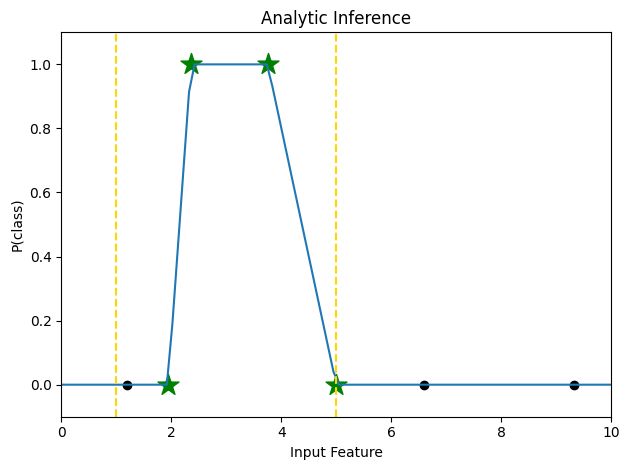

In [94]:
class AnalyticInference:

    def __init__(self, a_lo, b_hi):
        self.a_lo = a_lo
        self.b_hi = b_hi

        self.x1 = None
        self.x2 = None
        self.x3 = None
        self.x4 = None

    def fit(self, X, Y):
        X_pos, X_neg = set(), set()
        for x, y in zip(X, Y, strict=True):
            if y:
                X_pos.add(x)
            else:
                X_neg.add(x)
        assert len(X_pos) > 0, "TODO handle this later"
        m = next(iter(X_pos))
        X_neg_lo, X_neg_hi = set(), set()
        for x in X_neg:
            if x < m:
                X_neg_lo.add(x)
            else:
                X_neg_hi.add(x)
        self.x1 = max(X_neg_lo | {self.a_lo})
        self.x2 = min(X_pos)
        self.x3 = max(X_pos)
        self.x4 = min(X_neg_hi | {self.b_hi})

    def predict_proba(self, X):
        return np.piecewise(X, [X < self.x1, (self.x1 <= X) & (X < self.x2),
                                (self.x2 <= X) & (X < self.x3),
                                (self.x3 <= X) & (X < self.x4),
                                X >= self.x4],
                            [lambda x: 0,
                             lambda x: (x - self.x1) / (self.x2 - self.x1),
                             lambda x: 1,
                             lambda x: 1-(x - self.x3) / (self.x4 - self.x3),
                             lambda x: 0])

model = AnalyticInference(a_lo, b_hi)
model.fit(X, y)
grid_search_preds = model.predict_proba(X_test)

plt.figure()
plt.title("Analytic Inference")
plt.xlim((0.0, 10.0))
plt.ylim((-0.1, 1.1))
plt.xlabel("Input Feature")
plt.ylabel("P(class)")
plt.scatter(X, y, c="black")
plt.plot(X_test, grid_search_preds)
plt.vlines([a_lo, b_hi], -0.1, 1.1, color="gold", linestyle="--")
plt.scatter([model.x1, model.x2, model.x3, model.x4], [0.0, 1.0, 1.0, 0.0], color="green", marker="*", s=250)
plt.tight_layout()
plt.show()